# CASE STUDY - topic modeling and feature engineering


[Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is the process of using domain knowledge of your data to create features that can be leveraged by machine learning.  That is not a hard definition, because sometimes it is used in a context where features are transformed for machine learning, but the inclusion of domain knowledge is not implied.  

It is unfortunately common that for large datasets engineered features are not easy to create.  When there are many features generally only a small number play an important roll when it comes to prediction.  Furthermore,  domain insight is even more difficult to fold into the model when there are hundreds or thousands of features to keep in mind.  However, there is a middle ground---much of the worlds knowledge is locked up in language.  In this case study we will use topic modeling to gather insight from text.  Ideally, the result of these types of experiments would be shared with domain experts to further engineer features that are relevant when it comes to your business opportunity.

In [98]:
import os
import re
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from string import punctuation, printable
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

try:
    import pyLDAvis
    import pyLDAvis.sklearn
except:
    raise Exception("'pip install pyldavis' before running this notebook")

pyLDAvis.enable_notebook()    
plt.style.use('seaborn')
%matplotlib inline

## supress all warnings (not to be used during development)
import warnings
warnings.filterwarnings("ignore")

## Synopsis

   >Goal:  AAVAIL has recently enabled comments on the core streaming service.  The data science team knows that   this will be an incredibly important source of data going forward.  It will be used inform customer retention, product quality, product market fit and more.  Comments are going live next week and being the diligent data scientist that you are your plan is to build a topic modeling pipeline that that will consume the comments and create visualizations that can be used to communicate with domain experts.
  
## Outline

1. EDA - summary tables, use tSNE to visualize the data
2. Create a transfomation pipelines for NMF and LDA
3. Use ldaviz and wordclouds to get insight into the clusters

## Data

Here we see how to load the data.

* [download the movie review data](http://www.nltk.org/nltk_data)
* For more examples of applications with these data see [NLTK's book chapter that uses these data](https://www.nltk.org/book/ch06.html)

In [20]:
data_dir = os.path.join("..","data")
movie_reviews = load_files(os.path.join(data_dir,"movie_reviews"), shuffle=True)
X = movie_reviews.data
y = movie_reviews.target
target_names = movie_reviews.target_names
print(X[0])

b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . \nwith the help of a trusty sidekick ( kevin pollack ) , they will stop at nothing to let the devil take over the world ! \nparts of this are actually so absurd , that they would fit right in with dogma . \nyes , the film is 

### QUESTION 1

The main focus of this exercise is to enable visualization of topics, but these topics can be used as additional 
features for prediction tasks.  The goal of this case study is to ensure that you are comfortable with natural language processing pipelines and topic modeling tools. 

There are many ways to process tokens (words, dates, emojis etc).  NLTK is often used to pre-process text data before the tokens are vectorized.  Generally, the tokens are modified via [stemming or lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).  The next code block provides a lemmatization function that makes use of the library [spacy](https://spacy.io/).  You will need to install it and download the English language reference material as follows.  Stopwords are words that are very common or otherwise irrelevant we use a default list here, but it is an important part of NLP pipelines that needs to be customized for the subject area. Use the following function to process the corpus (this can take a few minutes)

```bash
~$ pip install spacy
~$ python -m spacy download en
```

If you prefer to use NLTK then you could use a simple lemmatizer like the WordLemmatizer.

In [52]:
import spacy
STOPLIST = ENGLISH_STOP_WORDS
STOPLIST = set(list(STOPLIST) + ["foo"])

if not 'nlp' in locals():
    print("Loading English Module...")
    nlp = spacy.load('en')

def lemmatize_document(doc, stop_words=None):
    """
    takes a list of strings where each string is a document
    returns a processed list of strings
    """
    
    if not stop_words:
        stop_words = set([])
  
    ## ensure working with string
    doc = str(doc)

    # First remove punctuation form string
    if sys.version_info.major == 3:
        PUNCT_DICT = {ord(punc): None for punc in punctuation}
        doc = doc.translate(PUNCT_DICT)

    # remove unicode
    clean_doc = "".join([char for char in doc if char in printable])
            
    # Run the doc through spaCy
    doc = nlp(clean_doc)

    # Lemmatize and lower text
    tokens = [re.sub("\W+","",token.lemma_.lower()) for token in doc ]
    tokens = [t for t in tokens if len(t) > 1]
    
    return ' '.join(w for w in tokens if w not in stop_words)    

## example usage
corpus = ['"You can fool some of the people all of the time, and all of the people some of the time, but you can not fool all of the people all of the time". -- Abraham Lincoln']
processed = [lemmatize_document(doc, STOPLIST) for doc in corpus]
print(processed[0])
processed = [lemmatize_document(doc, None) for doc in corpus]
print("\n"+processed[0])

pron fool people time people time pron fool people time abraham lincoln

pron can fool some of the people all of the time and all of the people some of the time but pron can not fool all of the people all of the time abraham lincoln


In [55]:
## Use stemming or lemmatization to process the corpus
## YOUR CODE HERE
processed = [lemmatize_document(doc, STOPLIST) for doc in X]
print("processing done.")

processing done.


### QUESTION 2

Use the CountVectorizer from sklearn to vectorize the tokens.

Additional resources:

* [scikit-learn CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* [scikit-learn working with text](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

Because this is an exercise in visualization set the `max_features` to something like 1000.  In the context of supervised learning it is reasonable to grid-search to optimize this parameter.

In [61]:
## YOUR CODE HERE

max_features = 1000
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=max_features,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(processed)
print("ready")

ready


### QUESTION 3

Use model the corpus with LDA.  For example, you could use something like the following.

```python
n_topics = 10
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)

lda_model.fit(tf)
```

You could use a pipeline here to make it easier to iterate on changes.

* [scikit-learn's LDA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
* [scikit-learn's user guide for LDA](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation)

In [63]:
## YOUR CODE HERE
n_topics = 10
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)
lda_model.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

## QUESTION 4

Visualize the corpus using [pyldavis](https://github.com/bmabey/pyLDAvis).

```python
pyLDAvis.sklearn.prepare(lda_model,tf, tf_vectorizer, R=20)
```

* [PyLDAViz documentation](https://pyldavis.readthedocs.io/en/latest)
* [PyLDAViz demos](https://pyldavis.readthedocs.io/en/latest/readme.html#video-demos)

In [64]:
## YOUR CODE HERE

pyLDAvis.sklearn.prepare(lda_model,tf, tf_vectorizer, R=20)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.013777  0.011346       1        1  54.641507
8      0.002996 -0.001980       2        1  32.120675
7      0.023990 -0.010855       3        1   6.629073
5     -0.019760  0.033201       4        1   3.482827
2     -0.199825 -0.077976       5        1   1.998446
4      0.036368  0.193129       6        1   0.630903
6      0.165893 -0.129616       7        1   0.332683
0      0.000845 -0.004163       8        1   0.054629
3      0.001934 -0.005666       9        1   0.054629
1      0.001337 -0.007421      10        1   0.054628, topic_info=    Category          Freq   Term         Total  loglift  logprob
321  Default  10968.000000   film  10968.000000  20.0000  20.0000
607  Default   7752.000000   nthe   7752.000000  19.0000  19.0000
539  Default   6859.000000  movie   6859.000000  18.0000  18.0000
494  Default   4095.000000   make   4095.000000  17.0000  17.0000
854  Default   2254.000000  story   2254.000000  16.0000  16.0000
..       ...           ...    ...           ...      ...      ...
569  Topic10      0.268525    nhe   1602.325101  -1.1817  -6.6063
488  Topic10      0.264388   love   1269.748930  -0.9645  -6.6218
905  Topic10      0.262857  thing   1604.482611  -1.2043  -6.6276
996  Topic10      0.256529   year   1545.469198  -1.1912  -6.6520
989  Topic10      0.251449   work   1645.199044  -1.2738  -6.6720

[428 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         1  0.507329     000
0         2  0.286395     000
0         3  0.180020     000
0         4  0.016365     000
6         1  0.430372  accent
...     ...       ...     ...
999       2  0.152963   young
999       3  0.008566   young
999       4  0.057514   young
999       5  0.051395   young
999       6  0.004895   young

[1486 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 8, 6, 3, 5, 7, 1, 4, 2])

## QUESTION 5

Try different numbers of clusters until there is decent separation in the visualization

In [92]:
## YOUR CODE HERE

max_features = 1000
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=max_features,
                                stop_words='english')
n_topics = 30
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)

pipe = Pipeline([('tf', tf_vectorizer),
                 ('lda',lda_model)])

lda_transformed = pipe.fit_transform(processed)
tf = tf_vectorizer.fit_transform(processed)
pyLDAvis.sklearn.prepare(pipe['lda'], tf, pipe['tf'], R=20)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.016447  0.039400       1        1  62.763410
8     -0.000472  0.043279       2        1  25.621874
14     0.024709  0.007159       3        1   7.806541
28     0.110445  0.166800       4        1   0.724948
11     0.035907  0.072968       5        1   0.566126
15     0.200791  0.168129       6        1   0.475436
5      0.026226  0.106651       7        1   0.392457
22     0.299855 -0.252115       8        1   0.326293
16     0.044387  0.051908       9        1   0.202170
2      0.045467  0.036209      10        1   0.186037
24    -0.049386 -0.040693      11        1   0.135963
12     0.111148 -0.097746      12        1   0.129442
20    -0.018973  0.017907      13        1   0.109533
7      0.004608  0.029270      14        1   0.104977
21    -0.101228 -0.105180      15        1   0.087267
4     -0.075665 -0.016265      16        1   0.071746
29    -0.074157 -0.045401      17        1   0.059057
18    -0.034657 -0.003395      18        1   0.018209
6     -0.035796 -0.009908      19        1   0.018209
26    -0.040945 -0.009376      20        1   0.018209
23    -0.035592 -0.001682      21        1   0.018209
10    -0.040878 -0.012392      22        1   0.018209
0     -0.043898 -0.013664      23        1   0.018209
19    -0.047199 -0.016700      24        1   0.018209
13    -0.050741 -0.022205      25        1   0.018209
17    -0.048924 -0.019436      26        1   0.018209
25    -0.046434 -0.017656      27        1   0.018209
3     -0.047024 -0.017476      28        1   0.018209
27    -0.047227 -0.018953      29        1   0.018209
1     -0.047900 -0.019438      30        1   0.018209, topic_info=    Category          Freq   Term         Total  loglift  logprob
321  Default  10907.000000   film  10907.000000  20.0000  20.0000
607  Default   7714.000000   nthe   7714.000000  19.0000  19.0000
539  Default   6930.000000  movie   6930.000000  18.0000  18.0000
477  Default   3663.000000   like   3663.000000  17.0000  17.0000
494  Default   4091.000000   make   4091.000000  16.0000  16.0000
..       ...           ...    ...           ...      ...      ...
767  Topic30      0.086767  scene   2570.512156  -1.6854  -6.6374
718  Topic30      0.080087   real    839.621980  -0.6466  -6.7175
205  Topic30      0.080231    day    954.978306  -0.7736  -6.7157
967  Topic30      0.079821  watch   1132.881003  -0.9495  -6.7209
496  Topic30      0.079358    man   1774.676370  -1.4042  -6.7267

[1186 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.580118    000
0         2  0.245120    000
0         3  0.138902    000
0         6  0.008171    000
2         1  0.392596     90
...     ...       ...    ...
999       1  0.807647  young
999       2  0.124728  young
999       3  0.059277  young
999       5  0.003705  young
999       7  0.001235  young

[3049 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 15, 29, 12, 16, 6, 23, 17, 3, 25, 13, 21, 8, 22, 5, 30, 19, 7, 27, 24, 11, 1, 20, 14, 18, 26, 4, 28, 2])

The visualization here can help determine a reasonable number of number of clusters and it can serve as a communication tool.  If the goal was to find topics that are associated with customer profiles then you would likely work with folks in marketing to refine the clustering.  There are a couple of parameters than can be used to modify the clustering and visualization.  The discovery of meaningful topics is a form of feature engineering.

## QUESTION 6

If you were to use the topics from this model to inform clustering or supervised learning you would first need to be able to extract and represent them as a matrix.  Along the same lines if you were to populate a report with tabular descriptions of the data then you will need to be able to extract topic representations.  Here is a starter function

```python
def get_top_words(model, feature_names, n_top_words):
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        _top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words[str(topic_idx)] = _top_words
    return(top_words)
```

Use the function to print the top k words for each topic

In [76]:
## YOUR CODE HERE

def get_top_words(model, feature_names, n_top_words):
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        _top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words[str(topic_idx)] = _top_words
    return(top_words)

## create a matrix of the top words used to define each topic
top_words = 15
tf_feature_names = np.array(tf_vectorizer.get_feature_names())
top_words = get_top_words(lda_model,tf_feature_names,top_words)
all_top_words = np.array(list(set().union(*[v for v in top_words.values()])))

for key,vals in top_words.items():
    print(key," ".join(vals))
print("total words: %s"%len(all_top_words))

0 episode stand tell ill willis sex element hero message comic scare actual carry lawyer version
1 result real club short screenplay return trip deserve promise sean plot bit leader reach brown
2 film nthe school original time high story nthere dog begin mother character make problem power
3 piece singer hill color maybe nim completely question exciting mention appeal realistic important intelligent decision
4 movie good film character like nthe nbut joke nthere play family various action scene make
5 toy allen story animation tim sequel disney old forget tom figure life sell tv grow
6 movie character nthe guy film play twist bad action like audience work story scene nit
7 movie nthe eddie scene film story say inspire star like comedy rush central master write
8 angel murphy eddie human desire film ryan movie nthe dumb martin touch comedy nit attempt
9 film movie nthe character make good like nit time story just play scene ni come
10 nthe film movie good black actor father white child 

## QUESTION (EXTRA CREDIT) 7

If you used `fit_transform` on your original tokens you should have a `2000 x k` array where `k` is the number of topics you choose.  Create a PCA or tSNE visualization that projects the tf matrix into lower dimensional space then uses colors to indicate which documents belong to a topic (e.g. probability > 0.5).

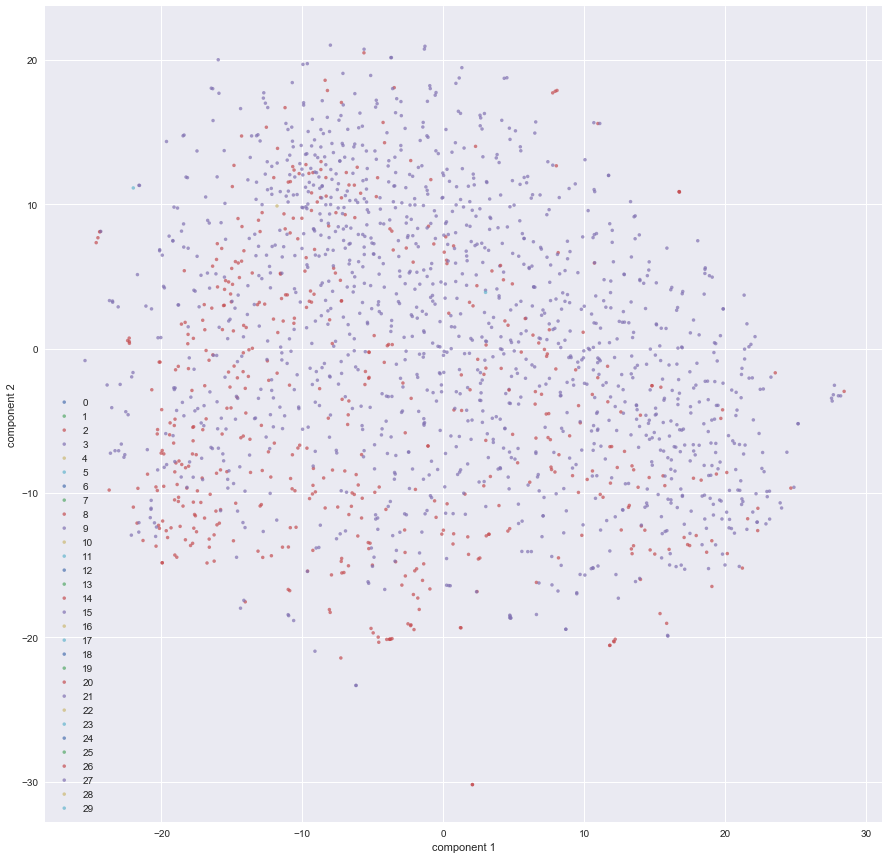

In [109]:
## YOUR CODE HERE

def make_tsne_plot(tf,lda_mat):
    
    fig = plt.figure(figsize=(15,15),facecolor='white')
    colors = np.array(['red','yellow','cyan','orange','black','grey','green','royalblue'])
    ax = fig.add_subplot(111)
    
    pca = PCA(50)
    pca_projected = pca.fit_transform(tf.todense(),2)
    
    tsne = TSNE(n_components=2,perplexity=50.0,init='pca')
    tsne_projected = tsne.fit_transform(pca_projected)
    
    for class_num in np.arange(n_topics):
        topic_inds = np.where(lda_mat[:,class_num] > 0.5)[0]
        ax.scatter(tsne_projected[topic_inds, 0],
                   tsne_projected[topic_inds, 1], 
                   edgecolor='none', marker='.', alpha=0.7, label=str(class_num))

    ax.set_xlabel('component 1')
    ax.set_ylabel('component 2')
    ax.legend();
 
make_tsne_plot(tf,lda_transformed)

<iframe src="https://player.vimeo.com/video/87110435" width="640" height="360"  frameborder="0" allowfullscreen></iframe>